# Example usage of `tslearn.adaptation`

`tslearn` provides an `adaptation` package that provides a time-series specific domain adaptation method. This method makes use of a base modality on which temporal alignment is performed _via_ (LR-)DTW.

In [1]:
%pylab inline
import numpy
import sys
sys.path.append("../../")  # Add tslearn base directory to Python path

from tslearn.adaptation import DTWSampler, _resampled

# preparing data, nothing very interesting here...

data = []
data.append(numpy.loadtxt("sample_data/Xi_ref.txt"))
data.append(numpy.loadtxt("sample_data/Xi_0.txt"))
data.append(numpy.loadtxt("sample_data/Xi_1.txt"))

d = data[0].shape[1]

max_sz = max([ts.shape[0] for ts in data])
dataset = numpy.empty((len(data), max_sz, d)) + numpy.nan
for idx, ts in enumerate(data):
    sz = ts.shape[0]
    dataset[idx, :sz] = ts
    
base_modality = 0  # Index of the base modality
ts_ref = 0  # Index of the reference series

dataset_without_ref = numpy.delete(dataset, ts_ref, axis=0)

Populating the interactive namespace from numpy and matplotlib


Note that, as done with this data, it is possible to use this method with time series of different lengths, as soon as there are NaNs padded at the end of the time series for them to have the same length.

Now, we can fit our sampler:

In [2]:
s = DTWSampler(n_samples=100, interp_kind="linear")
# We pass the base modality of the reference series to `fit`
s.fit(dataset[ts_ref, :, base_modality])
# Then, we feed `prepare_transform` with the base modality of series to be time-rescaled
s.prepare_transform(dataset_without_ref[:, :, base_modality])
# Finally, `transform` gets all modalities for these series and rescales them temporally
resampled_ts = s.transform(dataset_without_ref)

Let us have a look at the transformation:

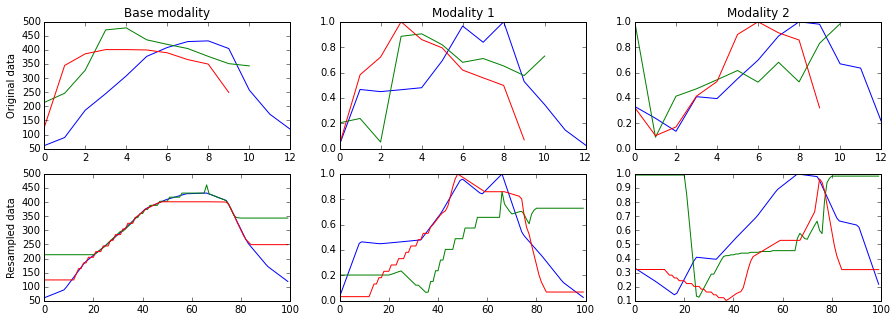

In [3]:
def fig_resample(original_data, resample_data, n_samples, d, ts_ref, base_modality):
    pylab.figure(figsize=(15, 5))

    for i in range(0, d):
        pylab.subplot(2, d, i + 1)  # Original data
        if i == 0:
            pylab.title("Base modality")
            pylab.ylabel("Original data")
        else:
            pylab.title("Modality %d" % i)
        for ts in original_data:
            sz = ts.shape[0]
            pylab.plot(numpy.arange(sz), ts[:, i])

        pylab.subplot(2, d, i + d + 1)  # Transformed data
        if i == 0:
            pylab.ylabel("Resampled data")
        pylab.plot(numpy.arange(n_samples), _resampled(original_data[ts_ref, :, i], n_samples=n_samples))
        for ts in resample_data:
            sz = ts.shape[0]
            pylab.plot(numpy.arange(n_samples), ts[:, i])

fig_resample(dataset, resampled_ts, s.n_samples, d, ts_ref, base_modality)

As one can see, after resampling, all time series are of length `n_samples`. Also, red and green curves are shifted to the right, based on the realignment of the base modality.

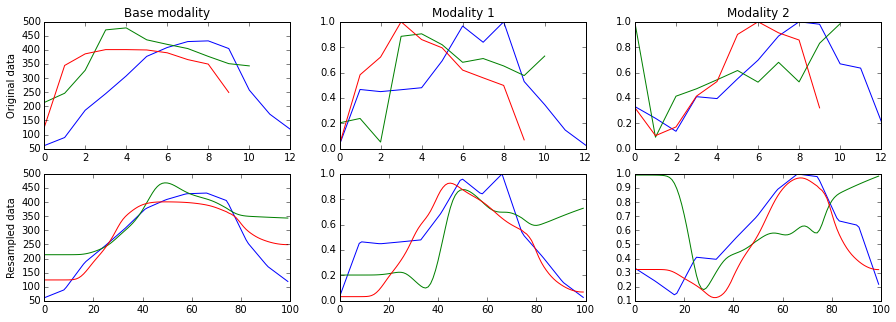

In [4]:
s = DTWSampler(n_samples=100, interp_kind="linear", metric="lrdtw", gamma_lr_dtw=10000.)
s.fit(dataset[ts_ref, :, base_modality])
s.prepare_transform(dataset_without_ref[:, :, base_modality])
resampled_ts = s.transform(dataset_without_ref)

fig_resample(dataset, resampled_ts, s.n_samples, d, ts_ref, base_modality)

One can note that obtained alignments tend to be smoother than when using DTW, at the cost of not enforcing perfect realignment between base modalities. Here, we need to use a very large value for `gamma_lr_dtw` for it to have an effect on the alignment since the magnitude of the base modality is large.